# Эпидемиологическая статистика

Рассмотрим онлайн-приложение https://epistat.wiv-isp.be .



Изучите явления:

1. Сезонность - Аденовирус, пневмония, хламидия, параинфлюенза.

2. Согласие в 2014 между динамикой бореллии и ротавируса.

3. Влияние фактора возраста - аденовирус, ВИЧ, пневмония.

Набор данных, которыми оперирует приложение {cite}`muyldermans2016`, содержит колонки:

-    Age возраст пациента (в годах);
-    DateMonday дата понедельника недели, когда делали запись;
-    Gender пол пациента;
-    Subject категория заболевания (возбудитель);
-    NUTS2 административное подразделение Бельгии, где сделали запись.

Каждая строчка в наборе данных - это запись о заболевании конкретного человека. Т.е. по одной записи можно установить, когда и с кем случилась неприятность. В некоторых случаях это серьезные заболевания вроде СПИД.

Однако, при анализе нас интересует количество случаев заболеваний за период времени в том или ином районе среди той или иной части населения.
Чтобы получать такие числа мы должны правильно отбирать строки в таблице и просто считать количество строк в полученных выборках.

*Эпидемиология* - наука на стыке микробиологии и социологии.

Загрузим набор данных и попробуем автоматизировать некоторые задачи.

In [84]:
%pylab inline
from ipywidgets import interact
import pandas as pd
import seaborn as sns
import re

import scipy.signal as signal
import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
D = pd.read_csv("d/epistat.csv")  #https://epistat.wiv-isp.be/data/public_cases.csv")
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295320 entries, 0 to 295319
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Age         289056 non-null  float64
 1   DateMonday  295320 non-null  object 
 2   Gender      295320 non-null  object 
 3   Subject     295320 non-null  object 
 4   NUTS2       282641 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.3+ MB


Как видно из количества ненулевых значений в наборе данных есть незначительное количество пропусков в данных о возрасте и регионе.


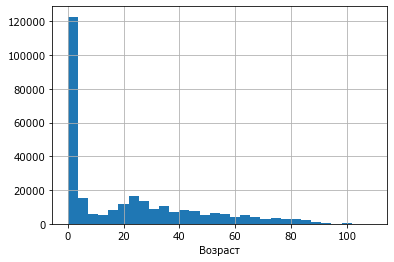

In [21]:
D.Age.hist(bins=30);
xlabel('Возраст');

На гистограмме выделяются две возрастные группы, подверженные инфекционным заболеваниям - дети до 7 лет и молодежь после 20.

In [4]:
D.Gender.value_counts()

M      151441
F      140440
U        2316
UNK      1123
Name: Gender, dtype: int64

Пол хоть и указан во всех записях, но обозначения U и UNK вставлены на местах отсутствующих значений.

In [5]:
D.loc[D.Gender.isin(['U','UNK']), 'Gender'] = NaN
D.Gender.value_counts()

M    151441
F    140440
Name: Gender, dtype: int64

Информация о возбудителях закодирована коротким кодом.

In [6]:
D.Subject.value_counts()

V_RSV     65945
CAM_SP    54545
CHLTRA    34782
SALM      26764
V_RTV     17332
V_ADV     12355
BRRBUR    12283
GIA_SP    10109
HIV        9006
V_PIV      8412
PNEU       8291
NEIGON     7727
V_HCV      7596
CRS_SP     3187
BORPER     2998
SHIG       2941
STRPYO     2612
YERENT     2211
ENTHIS     1555
V_HAV      1302
HAEINF      839
V_HTV       668
LIS_SP      579
MENI        558
VTEC        510
CHIK        135
CHLPSI       77
ZIKA          1
Name: Subject, dtype: int64

Преобладают простудные и кишечные инфекции. Странный единичный случай [вируса Зика](https://ru.wikipedia.org/wiki/Вирус_Зика).

In [7]:
D[D.Subject=='ZIKA']

,Age,DateMonday,Gender,Subject,NUTS2
247437,27.0,2015-12-07,F,ZIKA,31.0


Короткие кодовые названия часто используются в больших таблицах для формирования колонок фиксированной ширины. Также короткие обозначения удобны для подписей в рисунках. Однако латинские названия возбудителей гораздо понятнее. 

Создадим словарик соответствия кода и латинского названия. Структура данных `dict` используется для удобного доступа к множеству значений по ключу (коду).

In [22]:
kod_spec = {
    'BORPER':'Bordetella pertussis',
    'BRRBUR':'Borrelia burgdorferi',
    'CAM_SP':'Campylobacter sp.',
    'CHIK  ':'Chikungunya virus',
    'CHLPSI':'Chlamydia psittaci',
    'CHLTRA':'Chlamydia trachomatis',
    'CRS_SP':'Cryptosporidium',
    'ENTHIS':'Entamoeba histolytica',
    'GIA_SP':'Giardia sp.',
    'HAEINF':'Haemophilus influenzae',
    'HIV   ':'Lentivirus "HIV"',
    'LIS_SP':'Listeria monocytogenes',
    'MENI  ':'Neisseria meningitidis',
    'NEIGON':'Neisseria gonorrhoeae',
    'PNEU  ':'Streptococcus pneumoniae',
    'SALM  ':'Salmonella',
    'SHIG  ':'Shigella',
    'STRPYO':'Streptococcus pyogenes',
    'VTEC  ':'Escherichia coli "VTEC"',
    'V_ADV ':'Adenovirus',
    'V_HAV ':'Hepatitis A virus',
    'V_HCV ':'Hepatitis C virus',
    'V_HTV ':'Hantavirus',
    'V_PIV ':'Parainfluenza',
    'V_RSV ':'Respiratory Syncytial Virus',
    'V_RTV ':'Rotavirus',
    'YERENT':'Yersinia enterocolitica',
    'ZIKA  ':'Flavivirus "ZIKA"',
}
# пробелы проще вычистить в цикле
kod_spec = {k.strip():v for k,v in kod_spec.items()}

{'BORPER': 'Bordetella pertussis',
 'BRRBUR': 'Borrelia burgdorferi',
 'CAM_SP': 'Campylobacter sp.',
 'CHIK': 'Chikungunya virus',
 'CHLPSI': 'Chlamydia psittaci',
 'CHLTRA': 'Chlamydia trachomatis',
 'CRS_SP': 'Cryptosporidium',
 'ENTHIS': 'Entamoeba histolytica',
 'GIA_SP': 'Giardia sp.',
 'HAEINF': 'Haemophilus influenzae',
 'HIV': 'Lentivirus "HIV"',
 'LIS_SP': 'Listeria monocytogenes',
 'MENI': 'Neisseria meningitidis',
 'NEIGON': 'Neisseria gonorrhoeae',
 'PNEU': 'Streptococcus pneumoniae',
 'SALM': 'Salmonella',
 'SHIG': 'Shigella',
 'STRPYO': 'Streptococcus pyogenes',
 'VTEC': 'Escherichia coli "VTEC"',
 'V_ADV': 'Adenovirus',
 'V_HAV': 'Hepatitis A virus',
 'V_HCV': 'Hepatitis C virus',
 'V_HTV': 'Hantavirus',
 'V_PIV': 'Parainfluenza',
 'V_RSV': 'Respiratory Syncytial Virus',
 'V_RTV': 'Rotavirus',
 'YERENT': 'Yersinia enterocolitica',
 'ZIKA': 'Flavivirus "ZIKA"'}

В библиотеке `pandas` аналогом словаря  служит серия `pd.Series`, которая позволяет отбирать по нескольку названий по кодам.

In [9]:
species = pd.Series(kod_spec)
species

BORPER           Bordetella pertussis
BRRBUR           Borrelia burgdorferi
CAM_SP              Campylobacter sp.
CHIK                Chikungunya virus
CHLPSI             Chlamydia psittaci
CHLTRA          Chlamydia trachomatis
CRS_SP                Cryptosporidium
ENTHIS          Entamoeba histolytica
GIA_SP                    Giardia sp.
HAEINF         Haemophilus influenzae
HIV                  Lentivirus "HIV"
LIS_SP         Listeria monocytogenes
MENI           Neisseria meningitidis
NEIGON          Neisseria gonorrhoeae
PNEU         Streptococcus pneumoniae
SALM                       Salmonella
SHIG                         Shigella
STRPYO         Streptococcus pyogenes
VTEC          Escherichia coli "VTEC"
V_ADV                      Adenovirus
V_HAV               Hepatitis A virus
V_HCV               Hepatitis C virus
V_HTV                      Hantavirus
V_PIV                   Parainfluenza
V_RSV     Respiratory Syncytial Virus
V_RTV                       Rotavirus
YERENT      

Если заглянуть в <a href=view-source:https://epistat.wiv-isp.be/>исходный код веб-страницы</a> (нажать Ctrl-U на сайте Epistat), то можно найти много других расшифровок кодовых обозначений в таблице.

> Определите, кто скрывается за аббревиатурами:

- TUBECULT  (неужели культ ютуба?)
- TREPAL
- HANTA


Код на JavaScript содержит также информацию о соответствии кодов провинций и названий.
Информацию о названиях региона можно извлечь с помощью регулярных выражений следующим образом.

In [10]:
s='''case 10:
          e.province = 'Brussels';
          break;
        case 21:
          e.province = 'Antwerp';
          break;
        case 22:
          e.province = 'Limburg';
          break;
        case 23:
          e.province = 'East Flanders';
          break;
        case 24:
          e.province = 'Flemish Brabant';
          break;
        case 25:
          e.province = 'West Flanders';
          break;
        case 31:
          e.province = 'Walloon Brabant';
          break;
        case 32:
          e.province = 'Hainaut';
          break;
        case 33:
          e.province = 'Liege';
          break;
        case 34:
          e.province = 'Luxembourg';
          break;
        case 35:
          e.province = 'Namur';
          break;
        default:
          e.province = 'Unknown'
      }'''
tutu = re.findall(r'case (?P<code>\d+):.+?\.province = \'(?P<name>[\w ]+?)\'', s, re.S)
tutu

[('10', 'Brussels'),
 ('21', 'Antwerp'),
 ('22', 'Limburg'),
 ('23', 'East Flanders'),
 ('24', 'Flemish Brabant'),
 ('25', 'West Flanders'),
 ('31', 'Walloon Brabant'),
 ('32', 'Hainaut'),
 ('33', 'Liege'),
 ('34', 'Luxembourg'),
 ('35', 'Namur')]

Пары значений NUTS2-провинция мы можем оформить в виде таблички.

In [11]:
A = pd.Series(dict(tutu), name='Province').to_frame()
A.index = A.index.astype(int)
A

,Province
10,Brussels
21,Antwerp
22,Limburg
23,East Flanders
24,Flemish Brabant
25,West Flanders
31,Walloon Brabant
32,Hainaut
33,Liege
34,Luxembourg


На всякий случай можем добавить численность населения провинций.

In [12]:
s='''switch (e.NUTS2) {
        case 10:
          e.incidence = 100000 / 1119088;
          break;
        case 21:
          e.incidence = 100000 / 1764773;
          break;
        case 22:
          e.incidence = 100000 / 844621;
          break;
        case 23:
          e.incidence = 100000 / 1445831;
          break;
        case 24:
          e.incidence = 100000 / 1086446;
          break;
        case 25:
          e.incidence = 100000 / 1164967;
          break;
        case 31:
          e.incidence = 100000 / 382866;
          break;
        case 32:
          e.incidence = 100000 / 1317284;
          break;
        case 33:
          e.incidence = 100000 / 1077203;
          break;
        case 34:
          e.incidence = 100000 / 271352;
          break;
        case 35:
          e.incidence = 100000 / 476835;
          break;
        default:
          e.incidence = 0.1
'''
tutu = re.findall(r'case (?P<code>\d+):.+?\.incidence = 100000 / (?P<num>\d+)', s, re.S)
popu = pd.Series(dict(tutu), name='Population')
popu.index = popu.index.astype(int)

A = A.join(popu)
A

,Province,Population
10,Brussels,1119088
21,Antwerp,1764773
22,Limburg,844621
23,East Flanders,1445831
24,Flemish Brabant,1086446
25,West Flanders,1164967
31,Walloon Brabant,382866
32,Hainaut,1317284
33,Liege,1077203
34,Luxembourg,271352


In [13]:
D.NUTS2.unique()

array([32., 23., 22., 21., 10., 24., 31., nan, 33., 25., 35., 34.])

In [23]:
D.NUTS2 = D.NUTS2.fillna(0).astype(int)
A.loc[0, 'Province'] = '-'

## Подготовка данных про инфекционные заболевания

Для удобства сделаем колонки для отбора по годам и по месяцам.

In [38]:
D['Y'] = D.DateMonday.str.slice(0,4).astype(int)
D.Y.value_counts()

2015    42679
2012    40957
2013    40794
2014    39773
2011    37556
2008    31695
2010    31421
2009    30445
Name: Y, dtype: int64

In [39]:
D['YM'] = D.DateMonday.str.slice(0,7)

D['M'] = D.DateMonday.str.slice(5,7).astype(int)
D.M.value_counts().sort_index()

1     24352
2     20684
3     24863
4     20825
5     19795
6     21279
7     17888
8     20329
9     20575
10    22538
11    39180
12    43012
Name: M, dtype: int64

Для удобства можно добавить новые колонки с латинскими названиями возбудителей и названиями провинций.

In [25]:
D['Species'] = D.Subject.apply(lambda code: species[code])
D['Province'] = D.NUTS2.apply(lambda code: A.loc[code,'Province'])

## Анализ пустот

Перед тем как делать обобщающие выводы по результатам решения задач, прикинем полноту представленных в наборе записей.

Чувствительные данные, относящиеся к самим пациентам, могут отсутствовать умышленно из соображений анонимности при сборе данных. Колонки возраст, пол и провинция могут косвенно указывать на носителей заболевания.

Посмотрим, для каких возбудителей чаще всего не указана провинция.

In [26]:
D[D['Province']=='-'].Species.value_counts()

Salmonella                     2999
Lentivirus "HIV"               2369
Campylobacter sp.              1484
Respiratory Syncytial Virus    1453
Chlamydia trachomatis           940
Rotavirus                       498
Giardia sp.                     404
Hepatitis C virus               342
Borrelia burgdorferi            334
Adenovirus                      328
Neisseria gonorrhoeae           287
Shigella                        273
Parainfluenza                   204
Entamoeba histolytica           152
Streptococcus pneumoniae        110
Bordetella pertussis             95
Cryptosporidium                  86
Streptococcus pyogenes           76
Yersinia enterocolitica          63
Hepatitis A virus                47
Listeria monocytogenes           41
Haemophilus influenzae           30
Hantavirus                       29
Escherichia coli "VTEC"          22
Neisseria meningitidis           11
Chikungunya virus                 1
Chlamydia psittaci                1
Name: Species, dtype: int64

Интересно, много случаев СПИД без указания провинции. Еще больше сальмонеллёза. Давайте рассчитаем процент "скрытых" адресов относительно общей численности записей по каждой инфекции.

In [27]:
(D[D['Province']=='-'].Species.value_counts() / D.Species.value_counts()).sort_values() * 100

Chikungunya virus               0.740741
Chlamydia psittaci              1.298701
Streptococcus pneumoniae        1.326740
Neisseria meningitidis          1.971326
Respiratory Syncytial Virus     2.203351
Parainfluenza                   2.425107
Adenovirus                      2.654796
Cryptosporidium                 2.698463
Chlamydia trachomatis           2.702547
Borrelia burgdorferi            2.719205
Campylobacter sp.               2.720689
Yersinia enterocolitica         2.849389
Rotavirus                       2.873298
Streptococcus pyogenes          2.909648
Bordetella pertussis            3.168779
Haemophilus influenzae          3.575685
Hepatitis A virus               3.609831
Neisseria gonorrhoeae           3.714249
Giardia sp.                     3.996439
Escherichia coli "VTEC"         4.313725
Hantavirus                      4.341317
Hepatitis C virus               4.502370
Listeria monocytogenes          7.081174
Shigella                        9.282557
Entamoeba histol

Действительно, чаще всего фиксировались без указания адреса случаи заражения ВИЧ (HIV) - 26% от всей статистики.

А что с возрастом инфицированных ВИЧ в Бельгии?

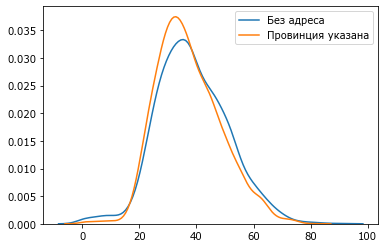

In [28]:
X = D[(D.Subject=='HIV') & (D.Age.notnull())]

sns.kdeplot(X[X.Province == '-'].Age, label='Без адреса')
sns.kdeplot(X[X.Province != '-'].Age, label='Провинция указана');

Большинство случаев заражения ВИЧ в детском возрасте (до 15 лет) в базе без указания адреса. В остальном распределения примерно совпадают.

А при каких заболеваниях чаще не указывали возраст?

In [31]:
(D[D.Age.isnull()].Species.value_counts() / D.Species.value_counts()).sort_values(ascending=False) * 100

Salmonella                     9.247497
Shigella                       3.264196
Neisseria gonorrhoeae          2.588327
Respiratory Syncytial Virus    2.312533
Chlamydia trachomatis          1.811282
Entamoeba histolytica          1.672026
Streptococcus pneumoniae       1.616210
Cryptosporidium                1.506119
Bordetella pertussis           1.501001
Neisseria meningitidis         1.433692
Hepatitis A virus              1.382488
Escherichia coli "VTEC"        1.176471
Giardia sp.                    1.147492
Hepatitis C virus              0.974197
Adenovirus                     0.874140
Listeria monocytogenes         0.863558
Borrelia burgdorferi           0.854840
Yersinia enterocolitica        0.814111
Campylobacter sp.              0.790173
Haemophilus influenzae         0.715137
Rotavirus                      0.675052
Streptococcus pyogenes         0.421133
Lentivirus "HIV"               0.410837
Hantavirus                     0.299401
Parainfluenza                  0.273419


Сальмонелла - кишечная инфекция. Ничего особенного.

## Динамика

При рассмотрении динамики заболеваемости во времени важно четко представлять иерархичность циклов, которыми оперируют эпидемиологи (как и другие люди).

Глобальные тренды оценивают по годам. 
Внутри года смотрят помесячную динамику.
В данном наборе минимальный срок - неделя, которая имеет четкую длительность - 7 дней.

Проблема осложняется тем, что в месяце нет четкого количества недель, потому что количество дней в разных месяцах варьирует.
Для правильного пересчета значений в иные периодические шкалы нужно использовать календарь. Функционал пересчета дат и периодов из одной шкалы в другую поддерживается в библиотеке `pandas`.

In [32]:
# создадим новую колонку, которая будет содержать объекты типа `datetime64`, со значениями, 
# дублирующими колонку DateMonday, которая содержит строки из 10 символов.
D['W'] = pd.to_datetime(D['DateMonday'])
# Чтобы легко было суммировать случаи заболевания, добавим в каждую строку по единице.
D['n']= 1

# Теперь полученную колонку сделаем индексом
D.set_index('W', drop=False, inplace=True)
# Индекс преобразуем в период - вместо одного дня понедельника будет диапазон из 7 дней
D = D.to_period('W', copy=False)
D.index.name = 'Time'

При трактовке динамики полезно понимать к какому типу инфекции относится то или иное заболевание. 

Эпидемиологические вспышки напрямую зависят от способа заражения. А он принципиально разный для:
- простудно-легочных заболеваний (Bordetella, Streptococcus, Haemophilus)
- кишечных расстройств (Shigella, Salmonella, Giardia)
- ЗППП (Neisseria gonorrhoeae, Chlamydia trachomatis)
- в общем безвредных паразитов, которые в редких случаях переходят в тяжелые системные заболевания (дизентерийная амёба, ВИЧ, Borrelia, Listeria, Neisseria meningitidis)

Предсказуемость динамики заболеваемости осложняется тем, что безобидный микроорганизм, который легко распознается и ликвидируется иммунными клетками, в отдельных случаях приводит к заболеванию.
Самый яркий пример - детские инфекции. Несмотря на то, что у новорожденных сильный иммунитет, часть которого приобретена пассивно через плаценту, при встрече с некоторыми микропаразитами врожденный иммунитет бессилен. А значит каждому ребенку "надо переболеть" ротавирусной (понос) или аденовирусной (сопли) инфекциями.

### Сезонная динамика

Восприимчивость к патогенам зависит от погоды: зимой легче заболевают одними инфекционными болезнями, летом - другими.

In [41]:
X = D[D.Species=='Rotavirus']

Для отображения динамики мы должны сгруппировать записи по неделям, сосчитать количество случаев в каждой группе и нарисовать график.

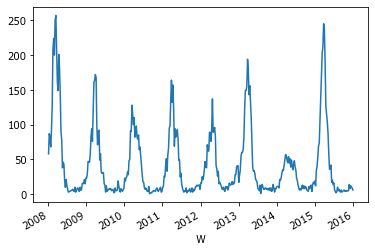

In [42]:
X.groupby('W').n.count().plot();

Так в колонке `n` одни единички, можно вместо подсчета использовать сумму. График будет тот же самый.

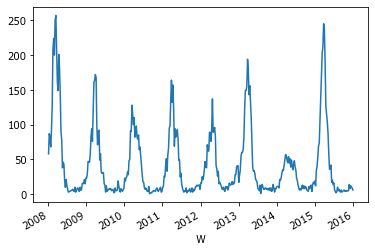

In [43]:
X.groupby('W').n.sum().plot();

Для наложения графиков годовой динамики один поверх другого нужно сделать то же самое, но для выборки по каждому году. При итерации групп в цикле мы на каждом шаге получаем имя группы и выборку строк для этой группы.

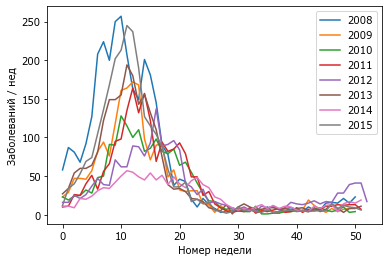

In [44]:
for glabel,g in X.groupby('Y'):
    # группируем по неделям и берем суммарные значения
    vv = g.groupby('W').n.sum().values    
    plot(vv, label=glabel)

xlabel('Номер недели')
ylabel('Заболеваний / нед')
legend();

Четко виден резкий рост заболеваемости на 5-10 неделях года.

Для более гладкой динамики можно сгруппировать по месяцам.

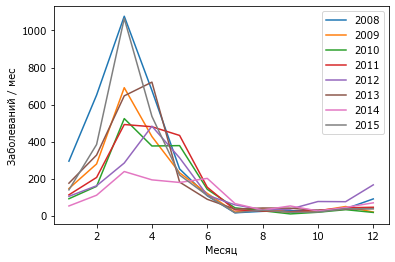

In [45]:
for glabel,g in X.groupby('Y'):
    # группируем по неделям и берем суммарные значения
    vv = g.groupby('M').n.sum()#.values
    
    plot(vv, label=glabel)

xlabel('Месяц')
ylabel('Заболеваний / мес')
legend();

Напомним возрастной состав заболевших ротавирусной инфекцией.

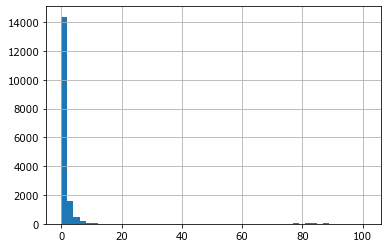

In [46]:
X.Age.hist(bins=50);

Маленькие дети и несколько глубоких старичков.

Рассмотрим детальней каждую категорию с учетом пола. При наложении нескольких распределений удобно строить ядерные оценки плотности (KDE, Kernel Density Estimation).

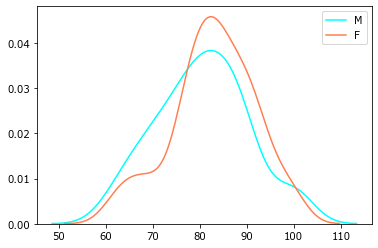

In [47]:
X_ = X[X.Age>60]
sns.kdeplot(X_[X_.Gender == 'M'].Age, label='M', color='cyan');
sns.kdeplot(X_[X_.Gender == 'F'].Age, label='F', color='coral');

Если строить классические гистограммы, то полупрозрачность дает возможность легко обнаруживать преобладание той или другой группы.

Так как возраст указан с точностью до года, то для подбробной гистограммы лучше задать не количество классов, а список границ классов, тогда каждому году будет четко соответствовать один столбик. 

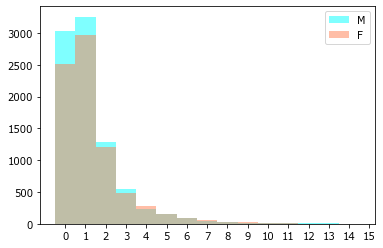

In [48]:
X_ = X[X.Age<20]
classes = arange(16)
hist(X_[X_.Gender == 'M'].Age, label='M', color='cyan', alpha=.5, bins=classes);
hist(X_[X_.Gender == 'F'].Age, label='F', color='coral',alpha=.5, bins=classes);
xticks(classes+.5, classes)
legend();

А старички также болеют весной?

Наложим нормализованную динамику для двух возрастных групп.

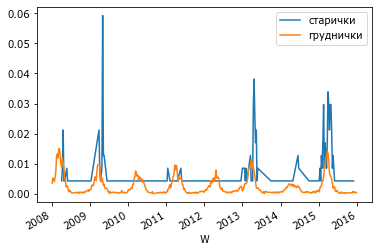

In [49]:
X_ = X[X.Age>60]
(X_.groupby('W').n.sum() / X_.n.sum()).plot(label='старички');
X_ = X[X.Age<8]
(X_.groupby('W').n.sum() / X_.n.sum()).plot(label='груднички');
legend();

Да, тоже по весне, но не так регулярно из-за малого количества случаев.

### Годовая динамика

Почему же все-таки в 2014 году была аномалия в заболеваемости ротавирусной инфекцией?
Почему детки из северной Бельгии в марте 2014 болели мало, а переболели только в следующем 2015 году?

Чтобы ответить на этот вопрос удобно рассмотреть изменения между годами независимо от изменений внутри года. Расположим оси смены лет и смены месяцев перпендикулярно, как это мы уже делали для визуализации температурных изменений.

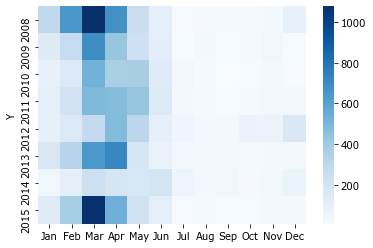

In [51]:
# momo = [datetime.date.strftime(x,'%b') for x in pd.DatetimeIndex(start='2000-01', end='2001-01', freq='M')]
momo = [datetime.date.strftime(x,'%b') for x in pd.date_range(start='2000-01', end='2001-01', freq='M')]

N = X.groupby(['Y','M']).n.count().unstack()
N.columns=momo
sns.heatmap(N, cmap='Blues');

Группировка по двум осям является типичной операцией, поэтому есть специальный метод - на русский переводится как "сводная таблица".

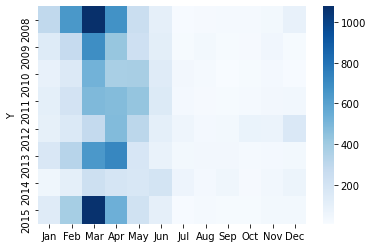

In [27]:
N = X.pivot_table('n', 'Y', 'M', 'sum')
N.columns=momo
sns.heatmap(N, cmap='Blues');

Давайте посмотрим отдельно для грудничков и годовалых младенцев.

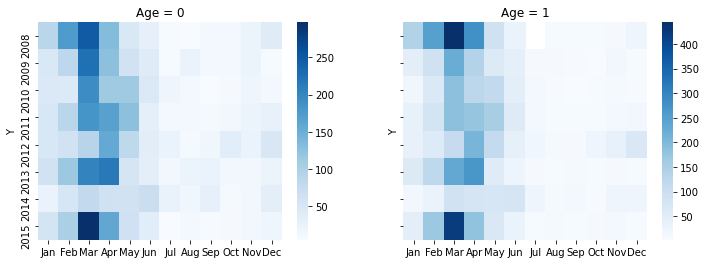

In [28]:
fig, ax = subplots(1,2, sharey=True, figsize=(12,4))

for iage, age in enumerate([0,1]):
    sca(ax[iage])
    N = X[X.Age==age].pivot_table('n', 'Y', 'M', 'sum')
    N.columns=momo
    sns.heatmap(N, cmap='Blues');
    title('Age = {}'.format(age))


Паттерн не различался. Значит дело не в возрасте.

Посмотрим паттерн температур для [Западной Фландрии](https://ru.wikipedia.org/wiki/Западная_Фландрия) с административным центром — городом Брюгге.

По координатам 51°00′ с. ш. 3°00′ в. д. можно найти данные метеорологических станций например с помощью сервиса http://climexp.knmi.nl/selectstation.cgi .
Ближайшая станция в [Лилле, Франция](
http://climexp.knmi.nl/gettempall.cgi?id=someone@somewhere&WMO=7015&STATION=LILLE&extraargs=).



На исходных данных {numref}`ta7015` видно отсутствие понижения среднемесячной температуры зимой 2014 года ниже 5 градусов по Цельсию.

::: {figure} ta7015

![](i/ta7015_2008-2018.png)

Среднемесячная температура в г. Лилль. Источник - http://climexp.knmi.nl/data/ta7015_2008:2018.png .
:::


Действительно в начале 2014 года температура держалась выше, чем обычно на 2 градуса.

Отобразим эти данных в виде `heatmap`.

In [52]:
u = 'http://climexp.knmi.nl/data/ta7015.dat'
T = pd.read_table(u, delim_whitespace=True, comment='#', header=None, na_values=-999.9,
                 names=momo)
T.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2015,3.8,3.5,6.8,10.4,13.1,16.2,18.8,19.1,13.7,10.6,10.1,9.5
2016,5.3,5.3,6.3,8.9,14.4,16.4,18.8,19.1,18.0,10.4,6.6,4.1
2017,1.6,6.2,9.7,9.6,15.6,19.4,19.3,18.5,14.5,13.6,7.0,4.9
2018,6.2,1.4,5.6,12.7,15.9,17.8,22.3,19.3,15.4,12.5,7.3,6.2
2019,3.5,6.6,9.0,10.9,12.6,18.2,20.1,NaN,NaN,NaN,NaN,NaN


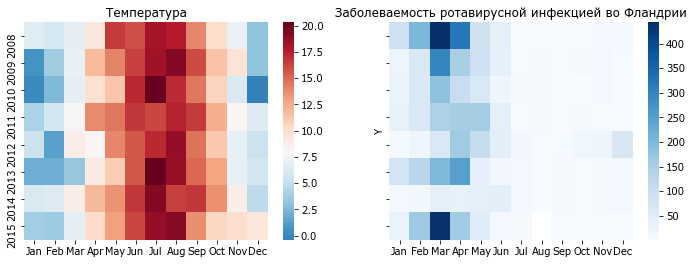

In [53]:
fig, ax = subplots(1,2, sharey=True, figsize=(12,4))

sca(ax[0])
sns.heatmap(T.loc[2008:2015], cmap='RdBu_r', center=8)
title('Температура');


sca(ax[1])
N = X[X.Province.isin(['West Flanders','East Flanders'])].pivot_table('n', 'Y', 'M', 'sum')
N.columns=momo
sns.heatmap(N, cmap='Blues');
title('Заболеваемость ротавирусной инфекцией во Фландрии');


В 2013 году была относительно холодная зима и март, что сопровождалось всплеском заболеваемости в марте и апреле. В 2014 году было необычно тепло и весеннее обострение прошло без мартовского пика.

Дабы выразить связь в численном виде посчитаем корреляцию между рядами для марта.

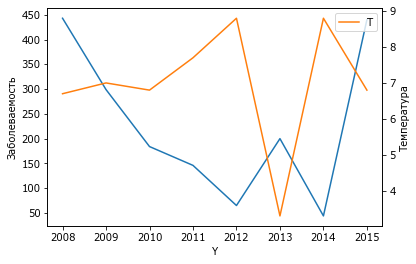

In [54]:
N['Mar'].plot(legend=False)
ylabel('Заболеваемость')
T.loc[2008:2015,'Mar'].plot(label='T', secondary_y=True);
ylabel('Температура')
legend();

In [55]:
corrcoef(N['Mar'], T.loc[2008:2015,'Mar'])

array([[ 1.        , -0.36375115],
       [-0.36375115,  1.        ]])

Если мы сравнимаем два ряда данных, то получаем четыре коэффициента, два из которых 1.0 (сам с собой всегда 1) и два - корреляция между рядами.
В данном случае это заметная отрицательная корреляция.

Из рисунка понятно, что если мы ограничим диапазон лет после 2010 года, то отрицательная корреляция будет еще сильнее.

In [56]:
corrcoef(N.loc[2011:2015, 'Mar'], T.loc[2011:2015,'Mar'])[0,1]

-0.41637479283604817

В 2012 году тоже был теплый март, но перед ним был холодный февраль. Можно усреднить данные за несколько месяцев.

In [57]:
iiyear = slice(2011,2015)
iimo = ['Jan','Feb','Mar','Apr','May']

corrcoef(N.loc[iiyear, iimo[:-1]].mean(axis=1), T.loc[iiyear, iimo[1:]].mean(axis=1))[0,1]

-0.5529228215230547

Итого мы обнаружили сильную отрицательную корреляцию между температурой в начале весны и масштабом весенней вспышки ротавирусной инфекции среди детей.

Корреляция может быть между любыми сходными по размеру данными.
Например, корреляция изменений температуры в марте с другими месяцами с начала 21-века.
Для таблиц `pandas` есть удобный метод для этого.

In [58]:
C = T.loc[2000:2018].corr()
C

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Jan,1.000000,0.293384,0.173692,0.271980,0.433983,-0.203485,-0.314160,-0.072938,-0.032642,-0.095994,-0.158574,0.233414
Feb,0.293384,1.000000,0.451556,0.254995,0.309534,0.026118,-0.573048,-0.173683,0.018472,-0.067392,0.130988,-0.034507
Mar,0.173692,0.451556,1.000000,0.176712,0.348536,0.408093,-0.510846,0.066309,-0.217353,-0.182912,0.070101,-0.059709
Apr,0.271980,0.254995,0.176712,1.000000,0.174350,0.169347,-0.172060,-0.071371,0.002518,0.053499,0.238175,0.083499
May,0.433983,0.309534,0.348536,0.174350,1.000000,0.178999,-0.109865,0.106526,-0.066111,-0.036186,0.042643,0.142281
Jun,-0.203485,0.026118,0.408093,0.169347,0.178999,1.000000,0.280509,0.051595,0.128666,0.049547,-0.112241,-0.077268
Jul,-0.314160,-0.573048,-0.510846,-0.172060,-0.109865,0.280509,1.000000,-0.087980,0.146808,0.228014,0.000477,-0.018975
Aug,-0.072938,-0.173683,0.066309,-0.071371,0.106526,0.051595,-0.087980,1.000000,-0.287177,-0.506997,0.019322,0.154475
Sep,-0.032642,0.018472,-0.217353,0.002518,-0.066111,0.128666,0.146808,-0.287177,1.000000,0.195307,0.138791,0.053726
Oct,-0.095994,-0.067392,-0.182912,0.053499,-0.036186,0.049547,0.228014,-0.506997,0.195307,1.000000,-0.076999,0.049747


Чтобы единицы по диагонали не мешали восприятию рисунка, их и половину значений маскируют.

In [59]:
mask = np.triu(np.ones_like(C))
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

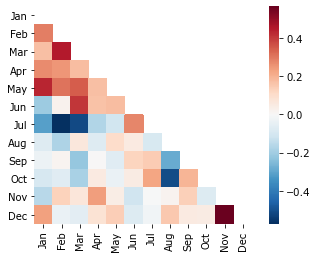

In [60]:
sns.heatmap(C, cmap='RdBu_r', center=0, square=True, mask=mask);

На пересечении месяцев между друг другом выделяются противоположности Июль и Февраль, а также Октябрь и Август. Сходную динамику (высокая полжительная корреляция) демонстрируют Февраль-Март и Ноябрь-Декабрь. И, внезапно также Май и Январь.

Тот же прием для данных по годовой динамике заболеваемости ротавирусной инфекцией.

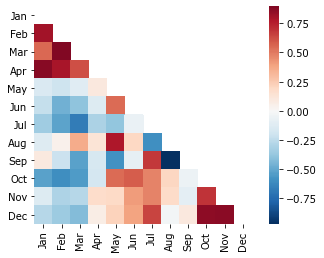

In [61]:
C = N.corr()
sns.heatmap(C, cmap='RdBu_r', center=0, square=True, mask=mask);

### Разложение на компоненты

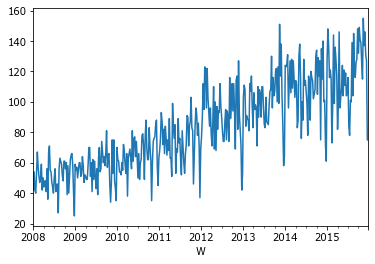

In [62]:
X = D[(D.Subject=='CHLTRA')]
X.groupby('W').n.count().plot();

На графике видны колебания, но при этом наблюдается тенденция к увеличению. Компоненты динамики (тренд, сезонная составляющая и др.) можно разделить специальными сезонными моделями из пакета `statsmodels`.

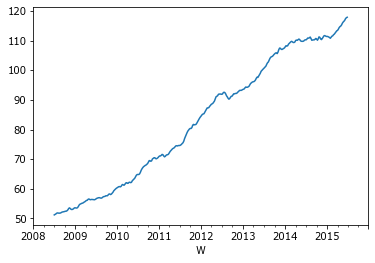

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

y = X.groupby('W').Subject.count()
result=seasonal_decompose(y, model='multiplicable', period=52)  #52.1714

result.trend.plot();

Несмотря на то, что количество недель в году неточное, сезонная динамика была эффективно выделена в отдельный компонент. Результаты разложения удобно визуализируются в единой шкале.

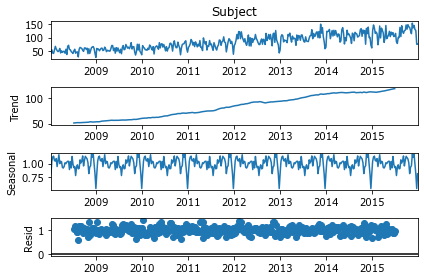

In [66]:
result.plot();

### Фазовые сдвиги

Корреляцию можно считать между любыми рядами данных. 

В колонках таблицы рассчитаем помесячную динамику. Исключим редкие болезни с невыраженной динамикой. Чтобы подчеркнуть циклические колебания также уберем глобальный тренд.

После вычитания среднего примерно половина значений становится отрицательными. Т.е. значения - это не количество, а отклонение количества от среднего тренда.

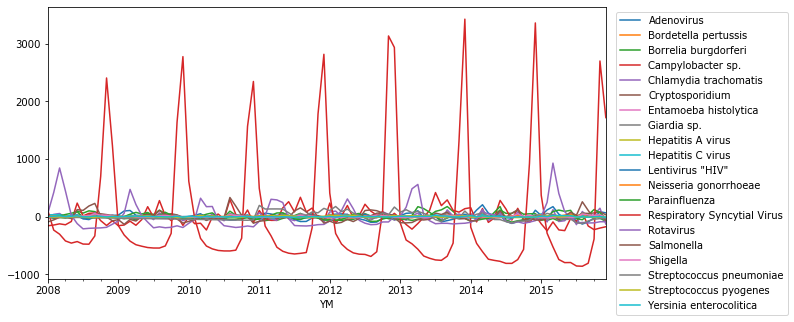

In [67]:
N = D.groupby(['YM','Species']).n.count().unstack()
N = N.loc[:,N.sum()>1000].fillna(0)
N[:] = detrend(N.values, 'linear', axis=0)
N.index =pd.to_datetime(N.index).to_period('M')
ax = N.plot(legend=False, figsize=(10,5));
legend(bbox_to_anchor=(1.01, 1));

Резко выделяется ярковыраженной годовой динамикой [Респираторно-синцитиальный вирус](https://ru.wikipedia.org/wiki/Респираторно-синцитиальный_вирус_человека), он же ортопневмовирус человека - возбудитель обычной простуды.

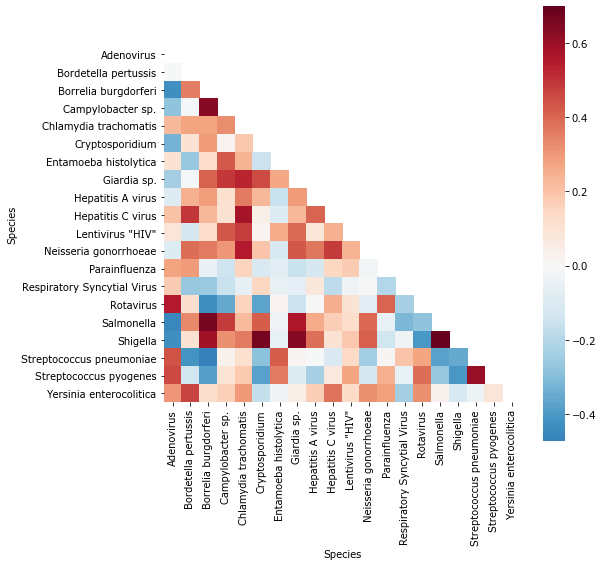

In [65]:
C = N.corr()
mask = np.triu(np.ones_like(C))

figure(figsize=(8,8))
sns.heatmap(C, cmap='RdBu_r', center=0, square=True, mask=mask);

Однако, временные ряды данных можно коррелировать не только с паралелльно изменяющимися во времени, но с самими собой, сдвинутыми по времени. Величина сдвига в шагах периода регистрации сигнала называется лаг.

Если мы сдвигаем ряд с циклической динамикой на несколько шагов, то корреляция падает, затем, когда мы доходим до противофазы (попадаем пиком туда, где ямка), то корреляция становится отрицательной, затем опять повышается. Первый большой пик автокорреляционной функции соответствует периоду основных колебаний.

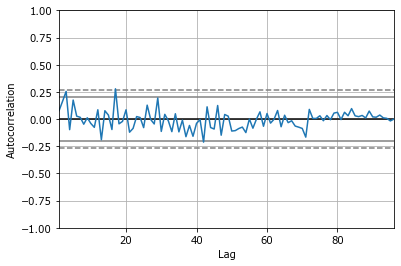

In [68]:
# pd.tools.plotting.autocorrelation_plot(N['Hepatitis C virus']); # old version
pd.plotting.autocorrelation_plot(N['Hepatitis C virus']);

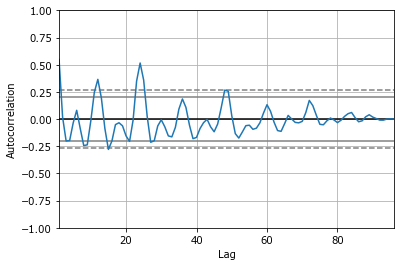

In [69]:
pd.plotting.autocorrelation_plot(N['Parainfluenza']);

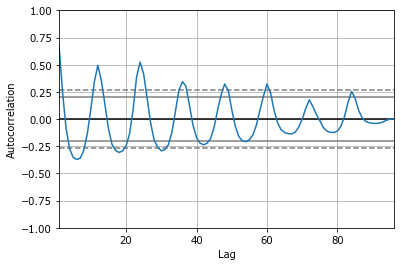

In [70]:
pd.plotting.autocorrelation_plot(N['Rotavirus']);

Для расчета исходной корреляционной функции без построения рисунка используют соответствующую функцию.

((96,), (191,))

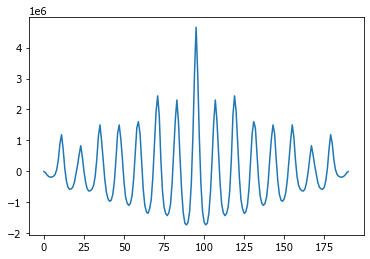

In [71]:
vv = N['Rotavirus']
c = correlate(vv, vv, 'full')
plot(c);
vv.shape, c.shape

Поскольку мы можем двигать один ряд значений относительно другого и вперед и назад, то полная функция имеет удвоенную длину. На предыдущем готовом рисунке была показана только ее правая половина, причем нормализованная к общей мощности сигнала, чтобы не выходить за рамки диапазона от -1 до 1.

Давайте получим нормализованные значения корреляции.

(96,)

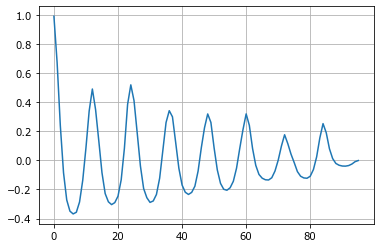

In [72]:
c = c[len(c)//2:]
c = c / (vv.var()) / len(c)
plot(c); grid(True);
c.shape

Вместо того, чтобы делить на дисперсию исходного сигнала, правильнее нормализовать входные ряды данных. Мы уже вычли тренд из динамики. Давайте теперь поделим каждую колонку на стандартное отклонение ее значений.

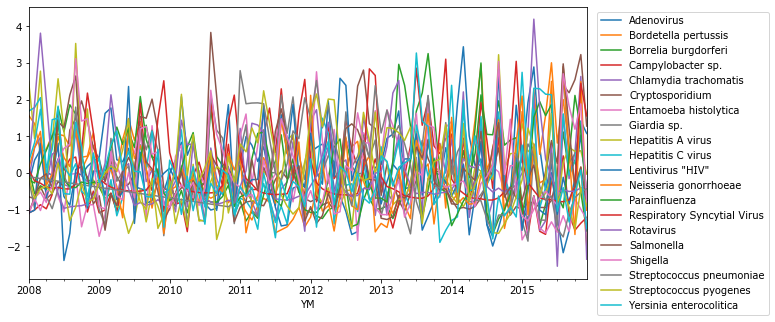

In [73]:
N = N / N.std()
ax = N.plot(legend=False, figsize=(10,5));
legend(bbox_to_anchor=(1.01, 1));

Резко преобладающие по численности пики ортопневмовируса (RSV) теперь незаметны на фоне остальных.

Годовые циклы имеют лаг в 12 месяцев. Однако какой лаг между динамикой разных заболеваний?
Например, ротавирусной и ортопневмовирусной инфекциями?

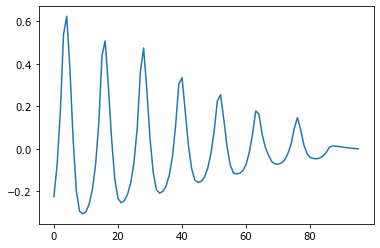

In [74]:
vv1 = N['Rotavirus']
vv2 = N['Respiratory Syncytial Virus']
c = correlate(vv1, vv2, 'full')
c = c[len(c)//2:]
c = c/len(c)
plot(c);

In [75]:
c.max(), c.argmax()

(0.6241196119581467, 4)

Между рядами высокая корреляция - 0.62, но сезонный пик в первом ряду значений сдвинут на 4 месяца относительно сезонного пика во втором ряду значений.

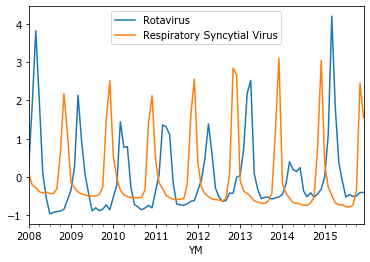

In [76]:
vv1.plot()
vv2.plot()
legend();

### Скачкообразная динамика

Некоторые болезни "привязаны" к некоторым странам, потому что там живут специфические переносчики каких-то из жизненных стадий паразитов.

Например, вирус chikungunya из Африки передается при укусах комаров, которые в Бельгии жить не должны. Это тропическая лихорадка. В Бельгии очень мало случаев. Посмотрим помесячную динамику. 

Сделаем помесячный индекс, охватывающий все данные в наборе.

In [79]:
monthindex = pd.to_datetime(D.DateMonday.unique()).to_period('M').unique()
# monthindex = pd.PeriodIndex(start='2008-01', end='2015-12')
monthindex

PeriodIndex(['2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06',
             '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12',
             '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
             '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12',
             '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12',
             '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
             '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
             '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
             '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
             '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
             '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
             '2014-01', '2014-02', '2014-03', '2014-

In [93]:
X = D[D.Subject=='CHIK']
N = X.groupby(['YM']).M.count()
N

YM
2012-02     1
2012-04     4
2012-05     1
2012-07     2
2012-10     1
2012-12     1
2013-07     6
2013-10     1
2014-03     1
2014-04     1
2014-05     3
2014-06     8
2014-07     9
2014-08    16
2014-09    15
2014-10     8
2014-11     6
2014-12     7
2015-01     4
2015-02     5
2015-04     4
2015-05     2
2015-06     7
2015-07     5
2015-08     6
2015-09     2
2015-10     3
2015-11     5
2015-12     1
Name: M, dtype: int64

Теперь сделаем пустую серию с полным индексом и заполним те значения, которые мы посчитали.

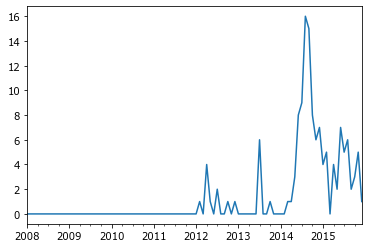

In [100]:
S = pd.Series(0, index=monthindex)
ii = pd.to_datetime(N.index).to_period('m')
S[ii] = N.values
S.plot();

Видно, что случаи болезни были единичными - возможно болезнь привозили туристы из поездок в теплые страны. Но с 2014 количество заболевших этой тропической лихорадкой резко возросло.

И этот график идеально совпадает с [волной мигрантов, захлестнувшей Европу в 2014-2015 гг](https://en.wikipedia.org/wiki/European_migrant_crisis#Global_refugee_crisis).
Среди этих мигрантов и были носители вируса Чикунгунья.

### Эффекты развития здравоохранения

На таком коротком временном отрезке (8 лет) трудно говорить о влиянии развития медицины, хотя безусловно оно есть.

В данном наборе есть один пример резкого снижения заболеваемости, который может быть объяснен успешными противоэпидемиологическими мерами.

Для демонстрации сделаем сводную таблицу динамики по годам, причем нормализуем ее, отняв среднее и разделив на стандартное отклонение.

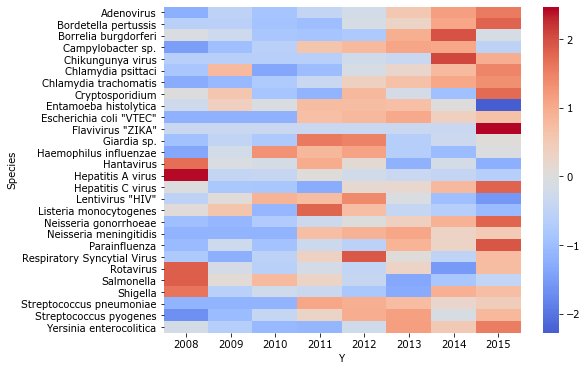

In [102]:
N = D.pivot_table('n', 'Y', 'Species', 'sum').fillna(0)
N = (N - N.mean())/ N.std()
figure(figsize=(8,6))
sns.heatmap(N.T, cmap='coolwarm', center=0);

Сильный "скачок" вниз наблюдался для заболеваний, вызванных Entamoeba histolytica и ВИЧ. 
После 2008 года только снижалась заболеваемость сальмонеллезом и гепатитом А.
Как мы знаем значимыми изменениями часто считают те, что выходят за 2 "сигмы". Поскольку те значения, что мы получили после нормализации, как раз в сигмах, то для наглядности мы можем скрыть значения, не достигшие "уровня значимости".

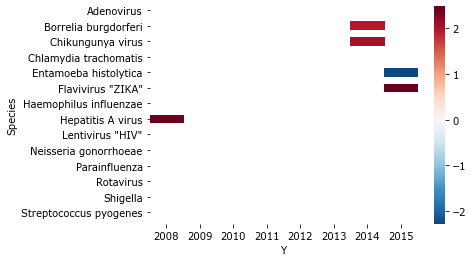

In [103]:
@interact(porog=(0.5, 2.5))
def _fig(porog=1.96):
    #figure(figsize=(8,6))
    sns.heatmap(N.T, cmap='RdBu_r', center=0, mask=N.T.abs()<porog);

Другой подход оценить отклонения - зафиксировать исходный нулевой уровень на базе начальных данных, например, до 2012 года. Тогда изменения от этого уровня в левой части рисунка будут нивелированы, в правой будут отражать относительные сдвиги в последующие годы.

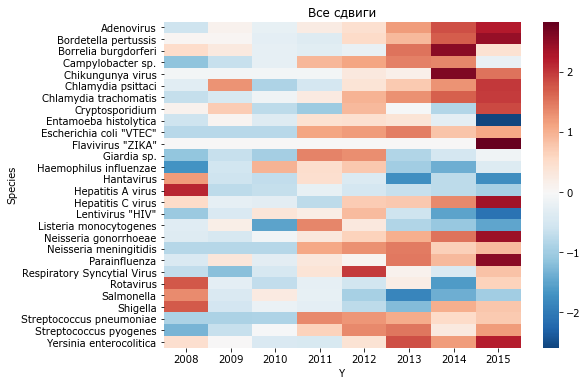

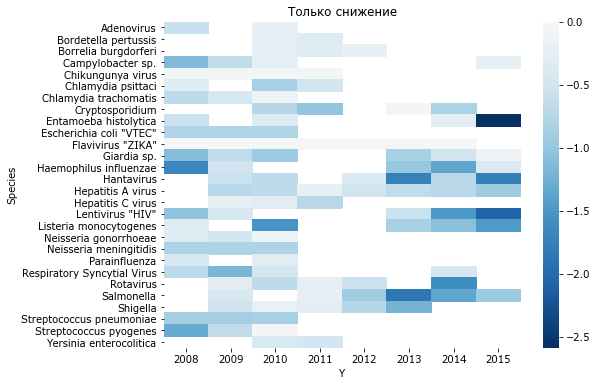

In [104]:
N_ = N - N[N.index < 2013].mean()
figure(figsize=(8,6))
sns.heatmap(N_.T, cmap='RdBu_r', center=0);
title('Все сдвиги')
figure(figsize=(8,6))
sns.heatmap(N_.T, cmap='RdBu_r', center=0, mask=N_.T>0);
title('Только снижение');

## Примеры решения задач

### Задача на прогноз по предыдущим значениям

По данным epistat постройте прогноз динамики распространения хламидиоза
на неделю, начинающуюся c 2014-09-01, на основании предыдущих данных, 
используя метод скользящего среднего с окном в 4 нед.
Ошибка в расчётах составит по сравнению с реальным уровнем?

In [105]:
X = D[D.Subject=='CHLTRA']
N = X.groupby('DateMonday').DateMonday.count()

nreal = N['2014-09-01']
nreal

114

In [106]:
nnprev = N[ (N.index < '2014-09-01') & (N.index > '2014-07-01') ]
nnprev

DateMonday
2014-07-07    107
2014-07-14     99
2014-07-21     78
2014-07-28    117
2014-08-04    113
2014-08-11     88
2014-08-18    120
2014-08-25    116
Name: DateMonday, dtype: int64

In [107]:
nprognoz = round(nnprev.iloc[-4:].mean())
nerror = nprognoz - nreal
nprognoz, nreal, nerror

(109, 114, -5)

### Задача на линейную экстраполяцию

```
Вы моделируете динамику заболеваемости по годам с помощью экстраполяции
линейной регрессионной модели за предыдущие 8 лет.
В каком регионе Бельгии прогнозируется самый сильный относительный рост
заболеваемости респираторно-синцитиальной инфекции в 2016 году (по отношению к 2015 году)?
Выберите один ответ:
a. Hainaut
b. Walloon Brabant
c. West Flanders
d. Antwerp
```

In [131]:
ny = 8
X = D[D.Subject=='V_RSV']
N = X.pivot_table('W', 'Y', 'Province', 'count').fillna(0)
N

Province,-,Antwerp,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
Y,,,,,,,,,,,,
2008,116,1129,1355,1066,591,453,169,433,173,343,143,1347
2009,77,1268,1022,969,876,237,191,347,212,112,164,1263
2010,114,1560,1195,1032,722,436,430,472,367,193,105,970
2011,375,1497,1354,1057,812,522,293,620,324,335,224,1225
2012,160,1740,1306,1466,987,621,766,691,383,462,257,1719
2013,227,1313,1365,1138,799,440,665,269,314,309,198,1261
2014,271,1270,1179,1075,692,383,297,282,343,288,83,1467
2015,113,1410,1194,1393,905,543,777,655,291,168,42,1678


In [132]:
#берем последние 8 лет
N = N.iloc[-ny:,:]

Потренируемся на одной колонке.

LinregressResult(slope=20.047619047619047, intercept=727.8333333333334, rvalue=0.3859663952074691, pvalue=0.34497278078037247, stderr=19.561858008321124)


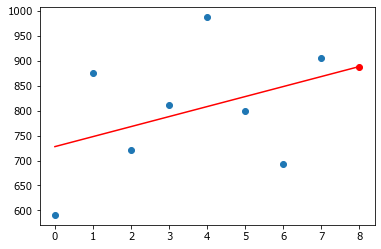

In [133]:
y = N.iloc[:,4]
x = arange(len(y))
plot(x,y,'o');

# добавим тренд
res = stats.linregress(arange(len(y)), y)
print(res)
xx = arange(ny+1)
yy = res.intercept + res.slope*xx
plot(xx,yy, '-r');

prognoz = yy[-1]
plot(xx[-1], yy[-1], 'ro');

Применим ко всем провинциям…

In [134]:
def _linreg(y):
    res = stats.linregress(arange(len(y)), y)
    return pd.Series(res, index=['slope', 'intercept', 'r', 'p', 'stderr'])

R = N.apply(_linreg, axis=0).T
R

,slope,intercept,r,p,stderr
Province,,,,,
-,12.773810,136.916667,0.307570,0.458644,16.133216
Antwerp,17.607143,1336.750000,0.221236,0.598520,31.685545
Brussels,1.428571,1241.250000,0.029092,0.945483,20.038632
East Flanders,42.214286,1001.750000,0.574132,0.136671,24.577063
Flemish Brabant,20.047619,727.833333,0.385966,0.344973,19.561858
Hainaut,17.511905,393.083333,0.371981,0.364204,17.840104
Liege,71.000000,200.000000,0.687845,0.059351,30.587501
Limburg,8.226190,442.333333,0.119869,0.777389,27.814631
Luxembourg,16.440476,243.333333,0.546954,0.160637,10.273005


In [135]:
prognoz = (R.intercept + R.slope*(ny)).astype(int)
prognoz = prognoz.clip(lower=0)
prognoz

Province
-                   239
Antwerp            1477
Brussels           1252
East Flanders      1339
Flemish Brabant     888
Hainaut             533
Liege               768
Limburg             508
Luxembourg          374
Namur               283
Walloon Brabant     109
West Flanders      1618
dtype: int32

Прирост относительно предыдущего значения...

In [136]:
last = N.iloc[-1,:]
rost = (prognoz - last) / last
rost

Province
-                  1.115044
Antwerp            0.047518
Brussels           0.048576
East Flanders     -0.038765
Flemish Brabant   -0.018785
Hainaut           -0.018416
Liege             -0.011583
Limburg           -0.224427
Luxembourg         0.285223
Namur              0.684524
Walloon Brabant    1.595238
West Flanders     -0.035757
dtype: float64

In [137]:
rost.idxmax()

'Walloon Brabant'

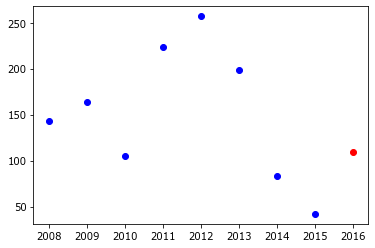

In [138]:
pname = 'Walloon Brabant'
plot(N.index, N[pname], 'bo')
plot(2016, prognoz[pname], 'ro');

В 2015 было всего 42 случая, но экстраполяция снижающегося тренда дала на 2016 год значение 109, что больше примерно в полтора раза.

### Задача на лаг в неделях


Каков лаг в неделях между сезонными колебаниями заболеваемости шигеллёза и аденовирусной инфекции?


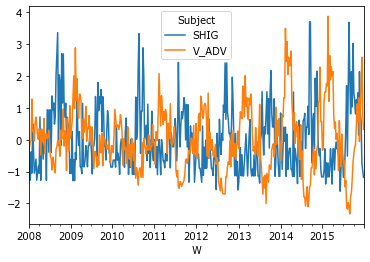

In [116]:
X = D[D.Subject.isin(['SHIG','V_ADV'])]
N = X.groupby(['W','Subject']).n.sum().unstack().fillna(0)
N[:] = detrend(N.values, 'linear', axis=0)
N = N / N.std()
N.plot();

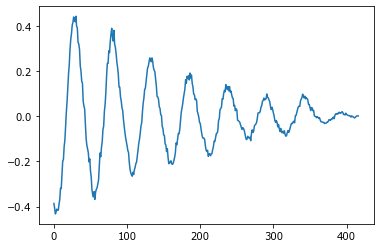

In [117]:
a = N.iloc[:,0]
b = N.iloc[:,1]
    
c = np.correlate(a, b, 'full')
c = c[len(c)//2:]
c = c/len(c)
    
plot(c);

In [118]:
365/7

52.142857142857146

Более подробно кросс-корелляционная функция на год (~52 недели).

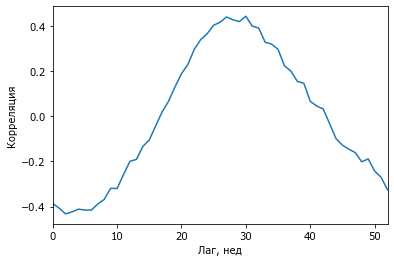

In [119]:
plot(c);
xlabel('Лаг, нед')
ylabel('Корреляция')
xlim(0, 52);

In [120]:
c.argmax()

30

Тридцать недель - это примерно 6 месяцев, т.е. простудное заболевание и кишечное отравление имеют пики зимой и летом.

### Задача на выявление корреляций

С каким заболеванием максимально коррелирует число случаев хламидиоза в Антверпене за весь период, отраженный в наборе данных
за период с 1990 по 2014


Один из хламидиозов - хламидиоз попугайчиков очень редкий. Наверно имеется в виду более распространенное ЗППП.

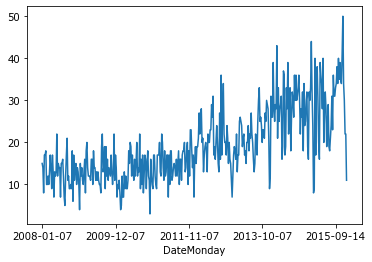

In [121]:
X = D[(D.Subject=='CHLTRA') & (D.Province == 'Antwerp')]
X.groupby('DateMonday').Subject.count().plot();

Мы видим рост заболеваемости. С какими наборами данных нужно посчитать корреляцию? Нужно получить динамику для всех инфекций в этом регионе.

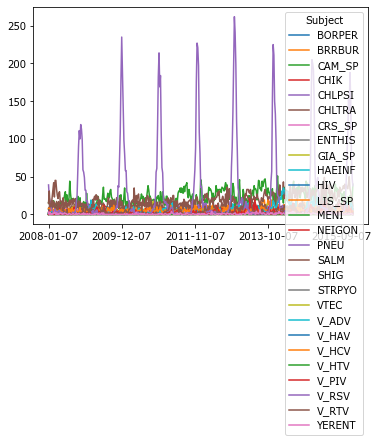

In [122]:
X = D[(D.Province == 'Antwerp')]


Y = pd.pivot_table(X, 'Province', 'DateMonday', 'Subject', aggfunc='count', fill_value=0)
Y.plot();

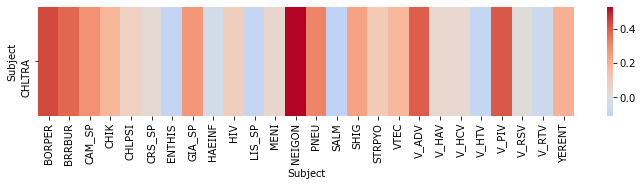

In [123]:
C = Y.corr()
figure(figsize=(12,2))
# удаляем пересечение с одноименной колонкой, потому что корреляция с самим собой всегда 1.0.
_C = C.loc[['CHLTRA']].T.drop('CHLTRA')

sns.heatmap(_C.T, cmap='coolwarm', center=0);

In [124]:
_C['CHLTRA'].idxmax()

'NEIGON'

In [125]:
species['NEIGON']

'Neisseria gonorrhoeae'

In [126]:
_C.loc['NEIGON']

Subject
CHLTRA    0.529694
Name: NEIGON, dtype: float64

Корреляция 53% с динамикой другого ЗППП - гонореей.

::: {seealso}
- [Статистические методы моделирования и мониторинга временных рядов подсчетов, пропорций и категориальных данных](https://surveillance.r-forge.r-project.org/)
surveillance - пакет для пространственно-временного моделирования и мониторинга эпидемических явлений
:::